In [255]:
import numpy as np
import pandas as pd
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
train_on_gpu = torch.cuda.is_available()
from sklearn.decomposition import PCA
from sklearn import preprocessing
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [256]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [421]:
AAPL_df = pd.read_csv('Preprocessed_AAPL_Data.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,Volume,Adj Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,^VIX_Close,...,TMO_Close,MSFT_Close,DHR_Close,TSLA_Close,LOW_Close,NEE_Close,AVGO_Close,LIN_Close,COST_Close,ACN_Close
0,27.332500,2015-01-02,212818400,24.565697,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,17.790001,...,128.119995,46.759998,64.988625,14.620667,67.699997,26.672501,100.089996,129.949997,141.610001,88.839996
1,26.562500,2015-01-05,257142000,23.873644,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,19.920000,...,126.360001,46.330002,64.344200,14.006000,66.080002,26.389999,98.489998,126.519997,140.000000,87.339996
2,26.565001,2015-01-06,263188400,23.875887,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,21.120001,...,125.180000,45.650002,63.904472,14.085333,66.230003,26.492500,96.250000,124.900002,141.850006,86.709999
3,26.937500,2015-01-07,160423600,24.210682,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,19.309999,...,128.929993,46.230000,64.291130,14.063333,68.199997,26.735001,98.849998,126.300003,144.320007,88.529999
4,27.972500,2015-01-08,237458000,25.140909,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,17.010000,...,130.270004,47.590000,65.284309,14.041333,69.639999,26.897499,103.790001,128.380005,145.559998,89.879997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,63814900,131.658981,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,20.870001,...,540.679993,238.729996,259.859985,123.150002,201.880005,84.169998,552.429993,329.329987,462.649994,266.089996
2003,130.029999,2022-12-27,69007800,129.831772,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,21.650000,...,545.440002,236.960007,260.880005,109.099998,201.710007,84.000000,553.539978,328.950012,458.500000,265.309998
2004,126.040001,2022-12-28,85438400,125.847855,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,22.139999,...,543.409973,234.529999,259.339996,112.709999,200.059998,83.160004,544.890015,325.910004,452.989990,263.119995
2005,129.610001,2022-12-29,75703700,129.412415,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,21.440001,...,557.010010,241.009995,266.850006,121.820000,202.259995,84.080002,557.809998,329.750000,456.529999,268.380005


In [321]:
from sklearn.preprocessing import MinMaxScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
    
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df,scaler
        
def split_train_test_data(df, lookback, pred_length=1, use_PCA= False, num_features = None):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
    print(len(res_list))
    data = []
    res_data = []
    if num_features == None:
        num_feature = len(df.columns.tolist())-1
    if use_PCA:
        pca_fit = PCA(num_features)
        PCA_list = np.array(df_list)[:,1:]
        PCA_list = pca_fit.fit_transform(PCA_list)
        PCA_list =scaler.fit_transform(PCA_list)
#         print(len(df_list),len(df_list[0]))
#         print(PCA_list.shape)
        df_list = np.array(df_list)
        df_list = np.concatenate((np.expand_dims(df_list[:,0], axis=1),  PCA_list), axis=1)
#         print(df_list.shape)


    for index in range(len(df_list) - lookback - pred_length + 1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
#         the_list= np.transpose(the_list)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + pred_length])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return x_train, y_train,x_val,y_val, x_test, y_test

In [322]:
class MyDataLoader(Dataset):
    def __init__(self, x_list, y_list):

        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    

    def __getitem__(self, idx):
        x_data = self.x_list[idx]
        y_data = self.y_list[idx]
        sample = {'Data': x_data, 'Labels': y_data}

        return sample

In [323]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch import nn, Tensor

# class TransAm(nn.Module):
#     def __init__(self, feature_size: int = 510, num_layers: int = 2, dropout: float = 0.1):
#         super(TransAm, self).__init__()
#         self.model_type = 'Transformer'
#         self.src_mask = None
#         self.pos_encoder = PositionalEncoding(feature_size)
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
#         self.decoder = nn.Linear(feature_size, 1)
#         self.linear1 = nn.Linear(SEQ_LEN, OUTPUT_DIMENSION)
#         self.init_weights()
#         self.src_key_padding_mask = None

#     def init_weights(self):
#         initrange = 0.1
#         nn.init.zeros_(self.decoder.bias)
#         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

#     def forward(self, src: torch.Tensor, seq_len: int = 510) -> torch.Tensor:
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         output = self.decoder(output)
#         output = torch.squeeze(output)
#         output = self.linear1(output)
#         return output

class TransformerModel(nn.Module):

    def __init__(self, d_input, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, output_size: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.embedding1 = nn.Linear(d_input, d_input)
        self.embedding2 = nn.Linear(d_input, 1)
        
#         self.pos_encoder = PositionalEncoding1D(d_model)
        self.pos_encoder = PositionalEncodingPermute1D(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        self.projection = nn.Linear(d_model, d_model)
        self.d_model = d_model
        self.decoder_1 = nn.Linear(d_model, d_model//2)
        self.decoder_2 = nn.Linear(d_model//2, output_size)
        self.relu = nn.ReLU()
        self.out_activation = nn.Tanhshrink()
#         self.activation = nn.Tanh()
#         self.activation = nn.LogSoftmax(dim=2)
#         self.activation = nn.Softmax(dim=2)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder_1.bias.data.zero_()
        self.decoder_1.weight.data.uniform_(-initrange, initrange)
        self.decoder_2.bias.data.zero_()
        self.decoder_2.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
#     def forward(self, src: Tensor, src_mask: Tensor, target: Tensor, trg_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         src = self.encoder(src) * math.sqrt(self.d_model)

        device = src.device
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        src_mask = mask
        x = torch.clone(src)
#         src = self.pos_encoder(src)
#         print(src.size())
        src = self.embedding1(src)
        src = self.embedding2(src)
        src = torch.squeeze(src, -1)
#         print(src.size())
            
        src = self.projection(src)
#         print(src.size())
        output = self.transformer_encoder(src, src_mask)
#         print(output.size())
#         trg = self.encoder(target) * math.sqrt(self.d_model)
#         trg = self.pos_encoder(target)
#         trg = self.projection(trg)
        
#         output = self.transformer_decoder(trg, output, tgt_mask = trg_mask)
        output = self.decoder_1(output)
        output = self.relu(output)
        output = self.decoder_2(output)
        x = torch.unsqueeze(x[:,-1,0], 1)
#         print(output.size())
        output = self.out_activation(output) + x
#         print(output.size())
        return output


    def _generate_square_subsequent_mask(self, sz):
            mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask

    def _gen_bias_mask(max_length): # added
        """
        Generates bias values (-Inf) to mask future timesteps during attention
        """
    #     np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
        np_mask = np.triu(np.full([max_length, max_length], 0), 1)
        torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)

        # Reshape to 4D Tensor to handle multiple heads
        return torch_mask.unsqueeze(0).unsqueeze(1)
    
def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc

class PositionalEncodingPermute1D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x) instead of (batchsize, x, ch)
        """
        super(PositionalEncodingPermute1D, self).__init__()
        self.penc = PositionalEncoding1D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 2, 1)

    @property
    def org_channels(self):
        return self.penc.org_channels
    
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [324]:
class Sequence_2_Conv(nn.Module):

    def __init__(self, d_input, d_model: int, d_hid: int,
                 nlayers: int, output_size: int, dropout: float = 0.5):
        super().__init__()
        self.embedding1 = nn.Linear(d_input, d_input//2 )
        self.embedding2 = nn.Linear(d_input//2, 1)
        
        self.encoder = nn.Conv1d(d_model, d_hid, 5)
        self.lstm_1 = nn.LSTM(d_hid, d_hid*2, num_layers=num_layers, batch_first=True,bidirectional =False)

        self.projection = nn.Linear(d_model, d_model)
        self.d_model = d_model
        self.decoder_1 = nn.Linear(d_hid*2, d_model)
        self.decoder_2 = nn.Linear(d_model, output_size)
        self.relu = nn.ReLU()
        self.out_activation = nn.Tanhshrink()
#         self.activation = nn.Tanh()
#         self.activation = nn.LogSoftmax(dim=2)
#         self.activation = nn.Softmax(dim=2)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder_1.bias.data.zero_()
        self.decoder_1.weight.data.uniform_(-initrange, initrange)
        self.decoder_2.bias.data.zero_()
        self.decoder_2.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
#     def forward(self, src: Tensor, src_mask: Tensor, target: Tensor, trg_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         src = self.encoder(src) * math.sqrt(self.d_model)

        x = torch.clone(src)
#         src = self.pos_encoder(src)
#         print(src.size())
        src = self.embedding1(src)
        src = self.embedding2(src)
        src = torch.squeeze(src, -1)
#         print(src.size())
            
        src = self.projection(src)
#         print(src.size())
#         src = src.permute(0, 2, 1)
        output = self.encoder(src)
#         print(output.size())
#         trg = self.encoder(target) * math.sqrt(self.d_model)
#         trg = self.pos_encoder(target)
#         trg = self.projection(trg)
        
#         output = self.transformer_decoder(trg, output, tgt_mask = trg_mask)
        output = self.decoder_1(output)
        output = self.relu(output)
        output = self.decoder_2(output)
        x = torch.unsqueeze(x[:,-1,0], 1)
#         print(output.size())
        output = self.out_activation(output) + x
#         print(output.size())
        return output


    def _generate_square_subsequent_mask(self, sz):
            mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask

    def _gen_bias_mask(max_length): # added
        """
        Generates bias values (-Inf) to mask future timesteps during attention
        """
    #     np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
        np_mask = np.triu(np.full([max_length, max_length], 0), 1)
        torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)

        # Reshape to 4D Tensor to handle multiple heads
        return torch_mask.unsqueeze(0).unsqueeze(1)

In [358]:
def train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma):
    n_epochs = 450
    last_epochs=0
    var_value = 0.0
    train_loss_res=[]
    valid_loss_res=[]
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i_batch, sample_batched in enumerate(train_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data=data_batch.float()
            target = labels_batch.float()
#             print(data.size())
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()

            optimizer.zero_grad()
            output = model(data)
#             print(output.size(),target.size(), var.size())
#             loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            loss = alpha * MAE_Loss(output, target)
            # criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)


        model.eval()
        for i_batch, sample_batched in enumerate(val_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data = data_batch.float()
            target = labels_batch.float()
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()
            output = model(data)

            # loss = criterion(output, target)
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            valid_loss += loss.item()*data.size(0)

    #     print(len(train_loader.sampler))
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        train_loss_res.append(train_loss)
        valid_loss_res.append(valid_loss)

        if valid_loss <= valid_loss_min:
            last_epochs=epoch
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'Trans_reg.pt')
            valid_loss_min = valid_loss
        if epoch-last_epochs>25:
            break
    return model

In [359]:
def combine_values(the_list,last=True):
    res=[]
    for i in range(len(the_list)):
        if last:
            if i==len(the_list)-1:
                for ii in range(len(the_list[i])):
                    res.append(the_list[i][ii])
            else:
                res.append(the_list[i][0])
        else:
            res.append(the_list[i][0])
    res=np.array(res)
    return res

In [360]:
def forecast_accuracy(forecast, actual):
    print(forecast.shape)
#     print(forecast[0], actual[0])
    ae = np.sum(np.abs(forecast - actual))    # AE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'ae':ae, 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def denormalise(the_df,thevalue):
    themax=the_df['Close'].max()
    themin=the_df['Close'].min()
    therange = themax - themin
    thevalue = thevalue*therange+themin
#     print(thevalue)
    return thevalue

In [361]:
def evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, the_df, lookback, pred_length, is_stock =  True):
    actual_values = np.concatenate((y_train.detach().cpu().numpy(),  y_val.detach().cpu().numpy()), axis=0)[:,0]
    actual_values = np.concatenate((actual_values,y_test.detach().cpu().numpy()[:,0]), axis=0)
    actual_values = denormalise(the_df,actual_values)
    print(actual_values.shape)
    actual = actual_values
#     combine_values(actual_values)
    print(actual.shape)
    devide = 16
    train_len = len(x_train)//devide

    # actual =  np.concatenate(actual)
    if train_on_gpu:
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_train[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_train[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                predict = temp_predict[:,0]
                predict_train = temp_predict
            else:     
                predict = np.concatenate((predict, temp_predict[:,0]), axis=None)
                predict_train = np.concatenate((predict_train, temp_predict), axis=0)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_val[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_val[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                val_predict = temp_predict[:,0]
                predict_val = temp_predict
            else:     
                val_predict = np.concatenate((val_predict, temp_predict[:,0]), axis=None)
                predict_val = np.concatenate((predict_val, temp_predict), axis=0)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_test[int(i*train_len):].cuda()).detach().cpu().numpy()
            else:
                temp_predict = model(x_test[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()
            
            if i ==0:
                test_predict = temp_predict[:,0]
                predict_test = temp_predict
            else:     
                test_predict = np.concatenate((test_predict, temp_predict[:,0]), axis=None)
                predict_test = np.concatenate((predict_test, temp_predict), axis=0)
                
#         val_predict = model(x_val.cuda()).detach().cpu().numpy()
#         test_predict = model(x_test.cuda()).detach().cpu().numpy()
    else:
        predict = model(x_train).detach().numpy()
        val_predict = model(x_val).detach().numpy()
        test_predict = model(x_test).detach().numpy()
    predict = denormalise(the_df,predict)
    val_predict = denormalise(the_df,val_predict)
    test_predict = denormalise(the_df,test_predict)
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[lookback:-pred_length+1])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, actual, label="Actual Prices", color='b')
    plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
    plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    
    torch.cuda.empty_cache()
    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))
    print(y_train.detach().numpy().shape)

    print(forecast_accuracy(y_train.detach().numpy(),predict_train))
    print(forecast_accuracy(y_val.detach().numpy(),predict_val))
    print(forecast_accuracy(y_test.detach().numpy(),predict_test))
    return forecast_accuracy(y_train.detach().numpy(),predict_train), forecast_accuracy(y_val.detach().numpy(),predict_val), forecast_accuracy(y_test.detach().numpy(),predict_test)


In [362]:
torch.cuda.empty_cache()

In [363]:
class Sequence_2_Conv(nn.Module):

    def __init__(self, d_input, d_model: int, d_hid: int,
                 nlayers: int, output_size: int, dropout: float = 0.5):
        super().__init__()
        
        self.embedding = nn.Linear(d_input, d_input)
        self.encoder1 = nn.Conv1d(d_input, d_hid, 5, padding = 2)
        self.lstm_1 = nn.LSTM(d_hid, d_hid*2, num_layers=num_layers, batch_first=True,bidirectional =False)
#         self.encoder2 = nn.Conv1d(d_hid, d_hid, 5, padding = 2)
        self.embedding1 = nn.Linear(d_hid*2, d_hid)
        self.embedding2 = nn.Linear(d_hid, d_model)

        self.projection = nn.Linear(d_model, d_model)
        self.d_model = d_model
        self.decoder_1 = nn.Linear(d_model, d_model)
        self.decoder_2 = nn.Linear(d_model, output_size)
        self.relu = nn.ReLU()
        self.out_activation = nn.Tanhshrink()

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder_1.bias.data.zero_()
        self.decoder_1.weight.data.uniform_(-initrange, initrange)
        self.decoder_2.bias.data.zero_()
        self.decoder_2.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
#     def forward(self, src: Tensor, src_mask: Tensor, target: Tensor, trg_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         src = self.encoder(src) * math.sqrt(self.d_model)

        x = torch.clone(src)
#         src = self.embedding(src)
        src = src.permute(0, 2, 1)
        src = self.encoder1(src)
#         src = self.encoder2(src)
        src = src.permute(0, 2, 1)
        src, _ = self.lstm_1(src)
        src = src[:, -1, :]
#         print(src.size())
#         src = self.pos_encoder(src)
#         print(src.size())
        src = self.embedding1(src)
#         src = self.relu(src)
        src = self.embedding2(src)
        src = torch.squeeze(src, -1)
#         print(src.size())
            
        output = self.projection(src)
#         print(output.size())
#         src = src.permute(0, 2, 1)
        
#         print(output.size())
#         trg = self.encoder(target) * math.sqrt(self.d_model)
#         trg = self.pos_encoder(target)
#         trg = self.projection(trg)
        
#         output = self.transformer_decoder(trg, output, tgt_mask = trg_mask)
        output = self.decoder_1(output)
        output = self.relu(output)
        output = self.decoder_2(output)
        x = torch.unsqueeze(x[:,-1,0], 1)
#         print(output.size())
        output = self.out_activation(output) + x
#         print(output.size())
        return output


In [394]:
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1 #by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1 #by default: stride==1 

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1 # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)
#             print('size',x_odd.size())
#             print('size',x_even.size())

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update)

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                 kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2) #B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)
        
    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim = 9, hid_size = 1, num_stacks = 1,
                num_levels = 3, num_decoder_layer = 1, concat_len = 0, groups = 1, kernel = 5, dropout = 0.5,
                 single_step_output_One = 0, input_len_seg = 0, positionalE = False, modified = True, RIN=False):
        super(SCINet, self).__init__()

        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.RIN=RIN
        self.num_decoder_layer = num_decoder_layer
        self.out_activation = nn.Tanhshrink()
        
        self.linear_out = nn.Linear(output_len*input_dim, output_len)

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        self.div_projection = nn.ModuleList()
        self.overlap_len = self.input_len//4
        self.div_len = self.input_len//6

        if self.num_decoder_layer > 1:
            self.projection1 = nn.Linear(self.input_len, self.output_len)
            for layer_idx in range(self.num_decoder_layer-1):
                div_projection = nn.ModuleList()
                for i in range(6):
                    lens = min(i*self.div_len+self.overlap_len,self.input_len) - i*self.div_len
                    div_projection.append(nn.Linear(lens, self.div_len))
                self.div_projection.append(div_projection)

        if self.single_step_output_One: # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

        ### RIN Parameters ###
        if self.RIN:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, input_dim))
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  #[T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
    
        return signal

    def forward(self, x):
        the_input = x
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)

        ### activated when RIN flag is set ###
        if self.RIN:
            print('/// RIN ACTIVATED ///\r',end='')
            means = x.mean(1, keepdim=True).detach()
            #mean
            x = x - means
            #var
            stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x /= stdev
            # affine
            # print(x.shape,self.affine_weight.shape,self.affine_bias.shape)
            x = x * self.affine_weight + self.affine_bias

        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        if self.num_decoder_layer == 1:
            x = self.projection1(x)
        else:
            x = x.permute(0,2,1)
            for div_projection in self.div_projection:
                output = torch.zeros(x.shape,dtype=x.dtype).cuda()
                for i, div_layer in enumerate(div_projection):
                    div_x = x[:,:,i*self.div_len:min(i*self.div_len+self.overlap_len,self.input_len)]
                    output[:,:,i*self.div_len:(i+1)*self.div_len] = div_layer(div_x)
                x = output
            x = self.projection1(x)
            x = x.permute(0,2,1)
            

        if self.stacks == 1:
            ### reverse RIN ###
            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means
                
            x = torch.flatten(x, start_dim=1)
            x = self.linear_out(x).float()
            the_input = torch.unsqueeze(the_input[:,-1,0], 1)
            x = self.out_activation(x) + the_input
#             self.out_activation
#             print(x.size())
            return x

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            
            ### Reverse RIN ###
            if self.RIN:
                MidOutPut = MidOutPut - self.affine_bias
                MidOutPut = MidOutPut / (self.affine_weight + 1e-10)
                MidOutPut = MidOutPut * stdev
                MidOutPut = MidOutPut + means

            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means
            
            return x, MidOutPut


2007
[[0.0297789  0.00720429 0.29053206 0.52571849 0.2633442  0.04735783
  0.60676935 0.49950171 0.48576826 0.31865121 0.51519265 0.40488545
  0.40086331 0.24762765 0.72130756 0.25275463 0.50433202 0.27807757
  0.2997979  0.56228739 0.62334107 0.07324122 0.75063202 0.42825426
  0.46617711 0.63493104 0.35049728 0.00818084 0.38206317 0.46312416
  0.47919745 0.6908724  0.17127921 0.48064309 0.19535697 0.55777266
  0.45130336 0.56904095 0.98218835 0.41180349 0.77543061 0.87024931
  0.59671118 0.70925178 0.48864196 1.         0.3061039  0.19442603]
 [0.02494904 0.01157706 0.33796578 0.55962853 0.29436548 0.05608177
  0.61884484 0.58421401 0.59654507 0.34491562 0.44781628 0.48154185
  0.3279927  0.21184208 0.65491683 0.28372541 0.48091051 0.30525754
  0.48185003 0.42624875 0.49878817 0.17875141 0.68943432 0.48931363
  0.49603233 0.63913427 0.38768538 0.23034061 0.43729055 0.45565415
  0.3227805  0.44271893 0.31550501 0.33441484 0.49981604 0.55741726
  0.39795224 0.32712331 0.61856049 0.07730

Epoch: 0 	Training Loss: 45.470438 	Validation Loss: 37.391941
Validation loss decreased (inf --> 37.391941).  Saving model ...
Epoch: 1 	Training Loss: 29.551065 	Validation Loss: 30.375326
Validation loss decreased (37.391941 --> 30.375326).  Saving model ...
Epoch: 2 	Training Loss: 21.626062 	Validation Loss: 21.300374
Validation loss decreased (30.375326 --> 21.300374).  Saving model ...
Epoch: 3 	Training Loss: 14.229493 	Validation Loss: 12.265217
Validation loss decreased (21.300374 --> 12.265217).  Saving model ...
Epoch: 4 	Training Loss: 11.340375 	Validation Loss: 8.064722
Validation loss decreased (12.265217 --> 8.064722).  Saving model ...
Epoch: 5 	Training Loss: 8.728937 	Validation Loss: 13.464258
Epoch: 6 	Training Loss: 8.034409 	Validation Loss: 8.921558
Epoch: 7 	Training Loss: 7.599081 	Validation Loss: 9.250296
Epoch: 8 	Training Loss: 6.955020 	Validation Loss: 8.602939
Epoch: 9 	Training Loss: 6.740970 	Validation Loss: 8.826466
Epoch: 10 	Training Loss: 6.2972

Epoch: 105 	Training Loss: 2.314587 	Validation Loss: 4.170094
Epoch: 106 	Training Loss: 2.121666 	Validation Loss: 4.136748
Epoch: 107 	Training Loss: 2.202487 	Validation Loss: 4.228227
Epoch: 108 	Training Loss: 2.444049 	Validation Loss: 4.081129
Epoch: 109 	Training Loss: 2.096692 	Validation Loss: 4.133503
Epoch: 110 	Training Loss: 2.218499 	Validation Loss: 4.123959
Epoch: 111 	Training Loss: 2.193765 	Validation Loss: 4.304900
Epoch: 112 	Training Loss: 2.383264 	Validation Loss: 4.241420
Epoch: 113 	Training Loss: 1.771545 	Validation Loss: 5.506674
Epoch: 114 	Training Loss: 2.206829 	Validation Loss: 4.154985
Epoch: 115 	Training Loss: 2.280203 	Validation Loss: 4.269778
Epoch: 116 	Training Loss: 2.087220 	Validation Loss: 4.165142
Epoch: 117 	Training Loss: 2.211921 	Validation Loss: 5.674341
Epoch: 118 	Training Loss: 2.051304 	Validation Loss: 4.107253
Epoch: 119 	Training Loss: 2.136395 	Validation Loss: 4.006892
Epoch: 120 	Training Loss: 2.019567 	Validation Loss: 4

Epoch: 228 	Training Loss: 1.485131 	Validation Loss: 3.875370
Epoch: 229 	Training Loss: 1.575001 	Validation Loss: 3.919000
Epoch: 230 	Training Loss: 1.501132 	Validation Loss: 3.721285
Epoch: 231 	Training Loss: 1.646101 	Validation Loss: 4.122571
(1977,)
(1977,)
predict (1187,)
Train Loss: 2.5954798993285
Val Loss: 5.6751565571072735
Test Loss: 6.547944447964053
predict (1187,)
val_predict (395,)
test_predict (395,)


C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


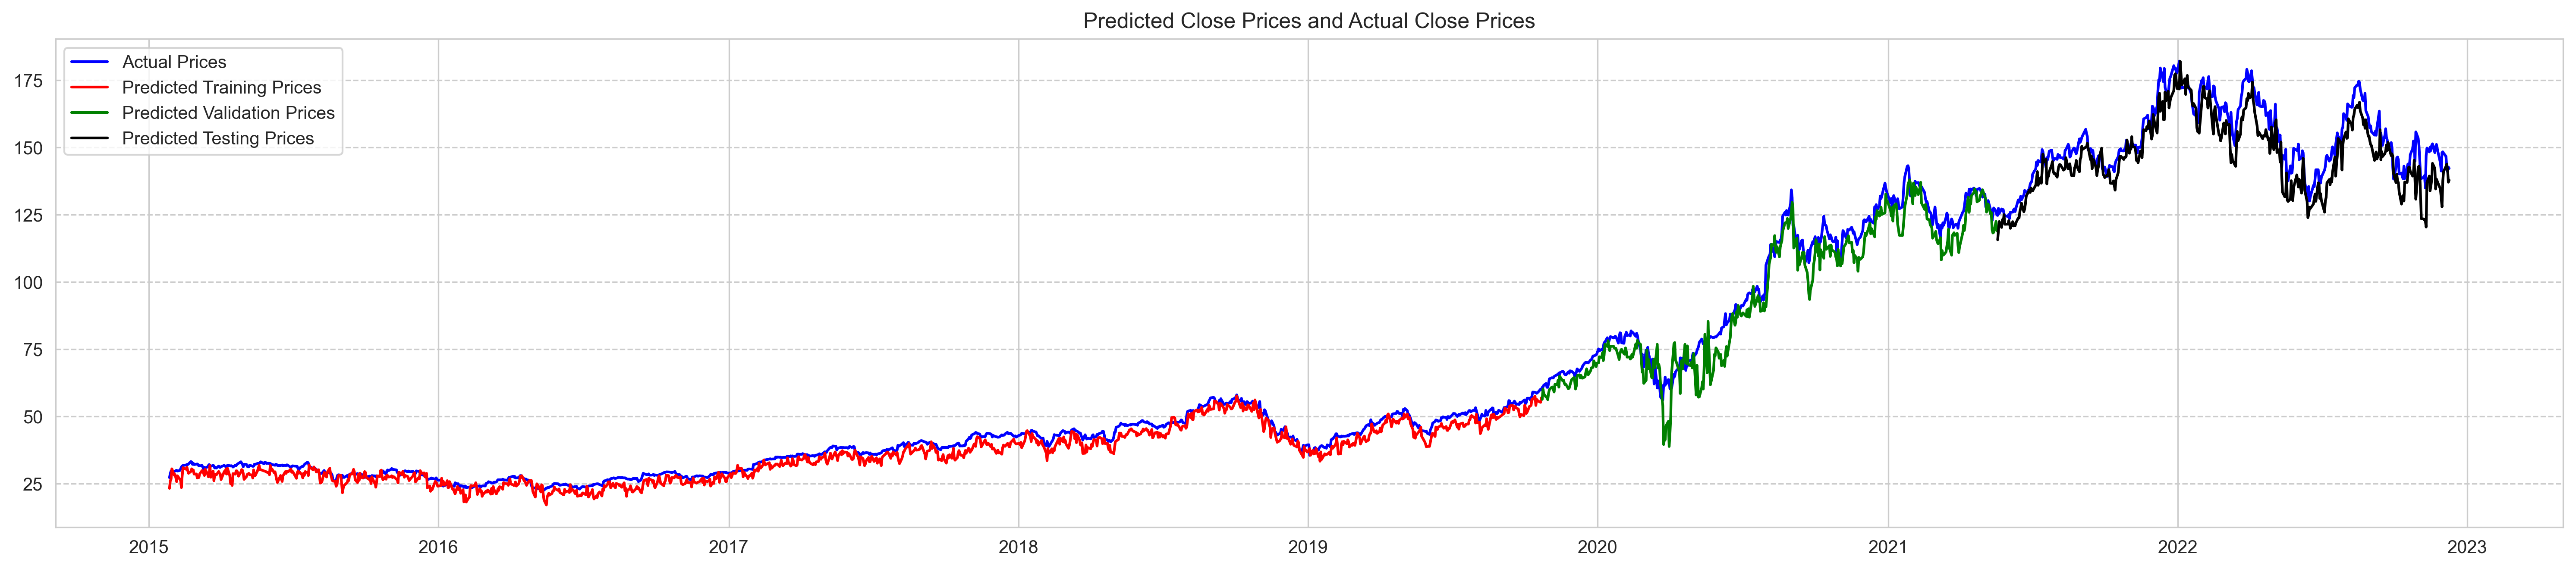

1187 395 395
1187 395 395
395
(1187, 15)
(1187, 15)
{'ae': 286.32086, 'mape': 1.2533699, 'me': 0.007384217, 'mae': 0.016080925, 'mpe': 0.32579562, 'rmse': 0.019536286688114964, 'corr': 0.9218960295791806, 'minmax': inf}
(395, 15)
{'ae': 236.63171, 'mape': 0.094093, 'me': 0.015455855, 'mae': 0.039937843, 'mpe': 0.042667918, 'rmse': 0.050887601698781065, 'corr': 0.9247843716380982, 'minmax': 0.08389806747436523}
(395, 15)
{'ae': 282.89978, 'mape': 0.060077827, 'me': 0.014499727, 'mae': 0.0477468, 'mpe': 0.021614151, 'rmse': 0.05897054715417518, 'corr': 0.3168742616300825, 'minmax': 0.05657994747161865}
(1187, 15)
(395, 15)
(395, 15)
(1977,)
(1977,)


C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


predict (1187,)
Train Loss: 2.5954798993285
Val Loss: 5.6751565571072735
Test Loss: 6.547944447964053
predict (1187,)
val_predict (395,)
test_predict (395,)


C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


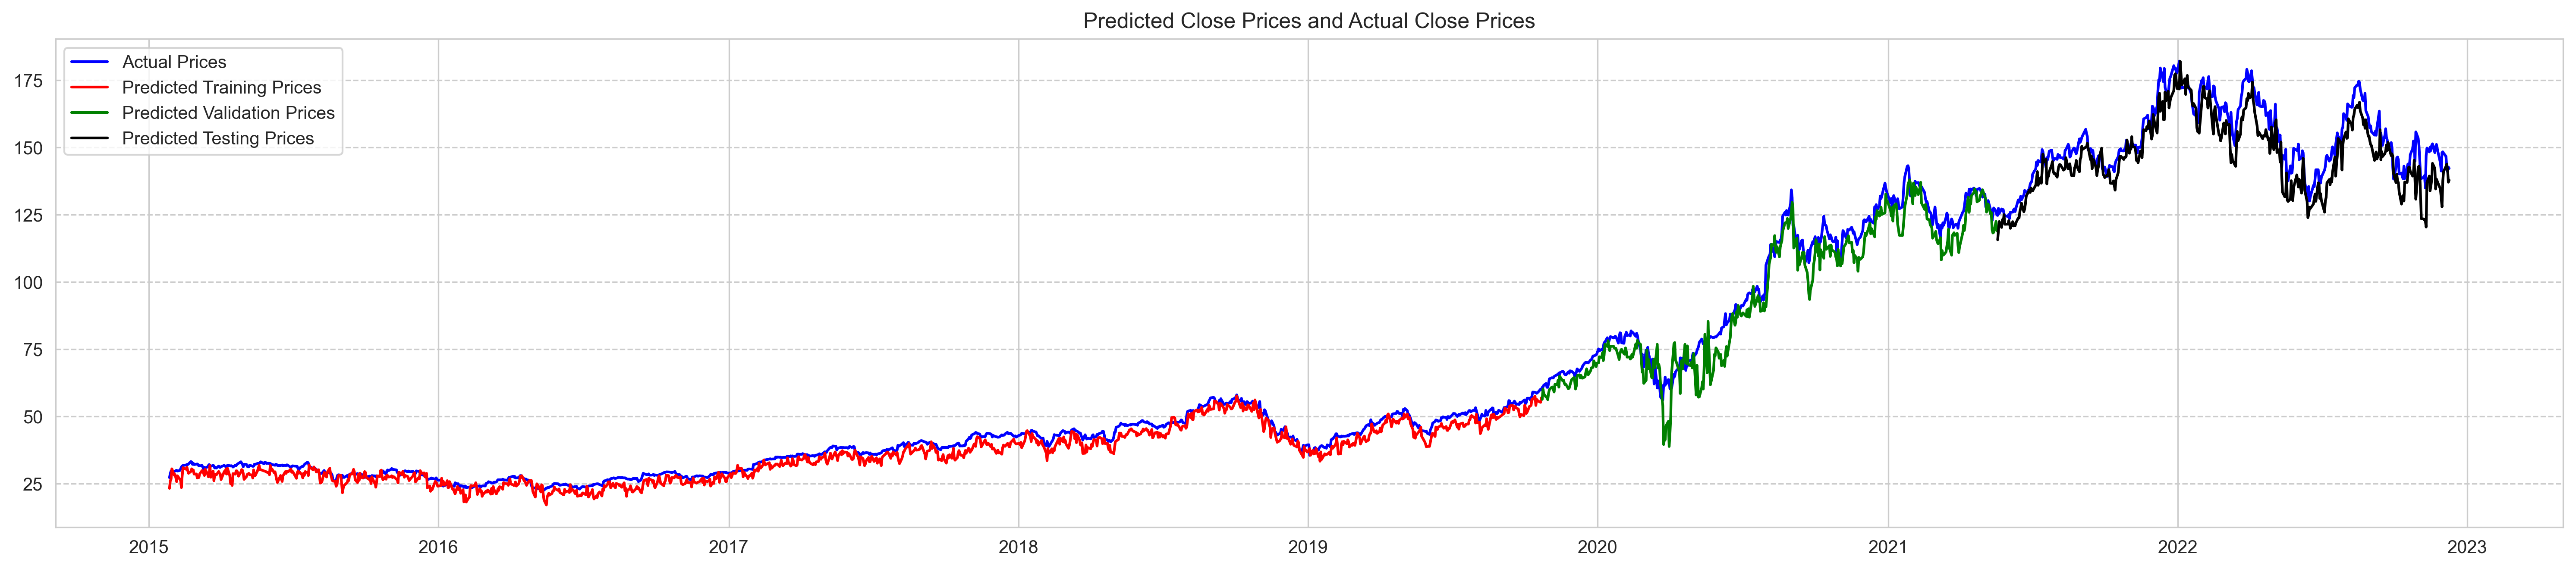

1187 395 395
1187 395 395
395
(1187, 15)
(1187, 15)
{'ae': 286.32086, 'mape': 1.2533699, 'me': 0.007384217, 'mae': 0.016080925, 'mpe': 0.32579562, 'rmse': 0.019536286688114964, 'corr': 0.9218960295791806, 'minmax': inf}
(395, 15)
{'ae': 236.63171, 'mape': 0.094093, 'me': 0.015455855, 'mae': 0.039937843, 'mpe': 0.042667918, 'rmse': 0.050887601698781065, 'corr': 0.9247843716380982, 'minmax': 0.08389806747436523}
(395, 15)
{'ae': 282.89978, 'mape': 0.060077827, 'me': 0.014499727, 'mae': 0.0477468, 'mpe': 0.021614151, 'rmse': 0.05897054715417518, 'corr': 0.3168742616300825, 'minmax': 0.05657994747161865}
(1187, 15)
(395, 15)
(395, 15)


C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


({'ae': 286.32086,
  'mape': 1.2533699,
  'me': 0.007384217,
  'mae': 0.016080925,
  'mpe': 0.32579562,
  'rmse': 0.019536286688114964,
  'corr': 0.9218960295791806,
  'minmax': inf},
 {'ae': 236.63171,
  'mape': 0.094093,
  'me': 0.015455855,
  'mae': 0.039937843,
  'mpe': 0.042667918,
  'rmse': 0.050887601698781065,
  'corr': 0.9247843716380982,
  'minmax': 0.08389806747436523},
 {'ae': 282.89978,
  'mape': 0.060077827,
  'me': 0.014499727,
  'mae': 0.0477468,
  'mpe': 0.021614151,
  'rmse': 0.05897054715417518,
  'corr': 0.3168742616300825,
  'minmax': 0.05657994747161865})

In [422]:
lookback = 16 # choose sequence length
pred_length = 15
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =True, num_features = 47) # change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_seq = len(x_train[0])
input_dim = len(x_train[0][0])
print(input_dim)
hidden_dim = 96
emsize = input_dim  # embedding dimension 192
d_hid = 96 # dimension of the feedforward network model in nn.TransformerEncoder 192
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
nhead = 5  # number of heads in nn.MultiheadAttention 12
dropout = 0.1  # dropout probability 0.1
num_layers = 3
output_dim = pred_length
print(input_dim)
# model = AttentionalLSTM(input_dim, output_dim, hidden_dim, num_layers, output_dim)
# model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
# model = Sequence_2_Conv(emsize,input_seq, hidden_dim, nlayers, output_dim, dropout)
model = SCINet(output_len = 15, input_len= 16, input_dim = input_dim, hid_size = 128, num_stacks = 1,
                num_levels = 2, concat_len = 0, groups = 1, kernel = 3, dropout = 0.1,
                 single_step_output_One = 0, positionalE =  True, modified = True)
if train_on_gpu:
    model.cuda()
# x = torch.randn(32, 16, 48).cuda()
# y = model(x)

# model = TransAm()
if train_on_gpu:
    model.cuda()
MAE_Loss = nn.L1Loss()
# MAE_Loss = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))
results_dic['SCINet_extra']=str(evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length))
evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

In [420]:
# lookback = 15 # choose sequence length
# pred_length = 15
# normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
# results_dic ={}
# for i in range(1, 48):
# #     lookback = i
# #     x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =True, num_features = 47)# change the num_feature value for using more features
#     if i == 48:
#         x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =False, num_features = i)# change the num_feature value for using more features
#     else:
#         x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =True, num_features = i)# change the num_feature value for using more features
#     print(x_train[0])

#     print('x_train.shape = ', x_train.shape)
#     print('y_train.shape = ', y_train.shape)
#     print('x_test.shape = ', x_test.shape)
#     print('y_test.shape = ', y_test.shape)
#     print('x_val.shape = ', x_val.shape)
#     print('y_val.shape = ', y_val.shape)
#     x_train = torch.from_numpy(x_train).type(torch.Tensor)
#     x_test = torch.from_numpy(x_test).type(torch.Tensor)
#     x_val = torch.from_numpy(x_val).type(torch.Tensor)
#     y_train = torch.from_numpy(y_train).type(torch.Tensor)
#     y_test = torch.from_numpy(y_test).type(torch.Tensor)
#     y_val = torch.from_numpy(y_val).type(torch.Tensor)

#     dataset_train = MyDataLoader(x_train, y_train)
#     dataset_test = MyDataLoader(x_test, y_test)
#     dataset_val = MyDataLoader(x_val, y_val)

#     batch_size = 32
#     train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
#     val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
#     test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

#     input_seq = len(x_train[0])
#     input_dim = len(x_train[0][0])
#     print(input_dim)
#     hidden_dim = 96
#     emsize = input_dim  # embedding dimension 192
#     d_hid = 96 # dimension of the feedforward network model in nn.TransformerEncoder 192
#     nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
#     nhead = 5  # number of heads in nn.MultiheadAttention 12
#     dropout = 0.1  # dropout probability 0.1
#     num_layers = 3
#     output_dim = pred_length
#     print(input_dim)
#     # model = AttentionalLSTM(input_dim, output_dim, hidden_dim, num_layers, output_dim)
#     # model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
# #     model = Sequence_2_Conv(emsize,input_seq, hidden_dim, nlayers, output_dim, dropout)
    

#     # model = TransAm()
    
#     # MAE_Loss = nn.L1Loss()
#     MAE_Loss = torch.nn.MSELoss()
#     NLL_Loss = nn.GaussianNLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#     alpha = 100
#     gamma = 0.0001

#     model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     #     model.load_state_dict(torch.load('1_googd_model_without.pt'))    
#     results_dic[str(i)]=str(evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length))
# with open("Trans_PCA", "w") as fp:
#     json.dump(results_dic,fp) 


# # # my_dict = {'a':11,'b':22,'c':33}


In [369]:
# lookback = 15 # choose sequence length
# pred_length = 15
# normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
# results_dic ={}
# hidden_dim = [64, 96, 128, 256]
# layers = [1, 3, 5]
# loss = ['l1', 'l2']
# optimiser = ['Adam',"SGD"]
# heads = [3, 5, 15]
# for the_hidden_dim in hidden_dim:
#     for the_layer in layers:
#         for the_loss in loss:
#             for the_optimiser in optimiser:
#                 for the_head in heads:
#                     x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =False, num_features = 20) # change the num_feature value for using more features
#                     print('x_train.shape = ', x_train.shape)
#                     print('y_train.shape = ', y_train.shape)
#                     print('x_test.shape = ', x_test.shape)
#                     print('y_test.shape = ', y_test.shape)
#                     print('x_val.shape = ', x_val.shape)
#                     print('y_val.shape = ', y_val.shape)
#                     x_train = torch.from_numpy(x_train).type(torch.Tensor)
#                     x_test = torch.from_numpy(x_test).type(torch.Tensor)
#                     x_val = torch.from_numpy(x_val).type(torch.Tensor)
#                     y_train = torch.from_numpy(y_train).type(torch.Tensor)
#                     y_test = torch.from_numpy(y_test).type(torch.Tensor)
#                     y_val = torch.from_numpy(y_val).type(torch.Tensor)

#                     dataset_train = MyDataLoader(x_train, y_train)
#                     dataset_test = MyDataLoader(x_test, y_test)
#                     dataset_val = MyDataLoader(x_val, y_val)

#                     batch_size = 32
#                     train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
#                     val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
#                     test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

#                     input_seq = len(x_train[0])
#                     input_dim = len(x_train[0][0])
#                     print(input_dim)
#                     hidden_dim = 128
#                     emsize = input_dim  # embedding dimension 192
#                     d_hid = the_hidden_dim # dimension of the feedforward network model in nn.TransformerEncoder 192
#                     nlayers = the_layer  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
#                     nhead = the_head  # number of heads in nn.MultiheadAttention 12
#                     dropout = 0.1  # dropout probability 0.1
#                     num_layers = 1
#                     output_dim = pred_length
#                     print(input_dim)
#                     # model = AttentionalLSTM(input_dim, output_dim, hidden_dim, num_layers, output_dim)
#                     model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
#     #                 model = Sequence_2_Conv(emsize,input_seq, hidden_dim, nlayers, output_dim, dropout)

#                     # model = TransAm()
#                     if train_on_gpu:
#                         model.cuda()
#                     MAE_Loss = nn.L1Loss()
#                     # criterion = torch.nn.MSELoss()
#                     NLL_Loss = nn.GaussianNLLLoss()

#                     if train_on_gpu:
#                         model.cuda()
#                     if the_loss == 'l1':
#                         MAE_Loss = nn.L1Loss()
#                     else:
#                         MAE_Loss = nn.MSELoss()
#                     if the_optimiser == 'Adam':
#                         optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#                     else:
#                         optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

#     #                 optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#                     alpha = 100
#                     gamma = 0.0001

#                     model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#                     #     model.load_state_dict(torch.load('1_googd_model_without.pt'))

#                     evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)
#                     results_dic['hidden_dim'+str(the_hidden_dim)+'num_layers'+str(the_layer)+'num_heads'+str(the_head)+'optimiser'+the_optimiser+'loss'+the_loss]=str(evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length))
# with open("Trans_GridSearch", "w") as fp:
#     json.dump(results_dic,fp) 
                

In [418]:
results_dic ={}

2007
[[0.0297789 ]
 [0.02494904]
 [0.02496473]
 [0.02730125]
 [0.03379333]
 [0.03398151]
 [0.02965345]
 [0.03117454]
 [0.03051593]
 [0.02584288]
 [0.02454132]
 [0.02882234]
 [0.03012389]
 [0.03459308]
 [0.0355026 ]
 [0.03569077]]
[[0.0297789 ]
 [0.02494904]
 [0.02496473]
 [0.02730125]
 [0.03379333]
 [0.03398151]
 [0.02965345]
 [0.03117454]
 [0.03051593]
 [0.02584288]
 [0.02454132]
 [0.02882234]
 [0.03012389]
 [0.03459308]
 [0.0355026 ]
 [0.03569077]]
x_train.shape =  (1187, 16, 1)
y_train.shape =  (1187, 15)
x_test.shape =  (395, 16, 1)
y_test.shape =  (395, 15)
x_val.shape =  (395, 16, 1)
y_val.shape =  (395, 15)
1
1
Epoch: 0 	Training Loss: 57.191285 	Validation Loss: 65.878815
Validation loss decreased (inf --> 65.878815).  Saving model ...
Epoch: 1 	Training Loss: 41.330996 	Validation Loss: 52.251513
Validation loss decreased (65.878815 --> 52.251513).  Saving model ...
Epoch: 2 	Training Loss: 31.964937 	Validation Loss: 42.530266
Validation loss decreased (52.251513 --> 42.53026

Epoch: 100 	Training Loss: 6.681707 	Validation Loss: 21.117147
Epoch: 101 	Training Loss: 6.814077 	Validation Loss: 17.193609
Epoch: 102 	Training Loss: 6.734337 	Validation Loss: 19.356542
Epoch: 103 	Training Loss: 6.746589 	Validation Loss: 18.765786
Epoch: 104 	Training Loss: 6.695823 	Validation Loss: 15.525564
Validation loss decreased (17.051701 --> 15.525564).  Saving model ...
Epoch: 105 	Training Loss: 6.667168 	Validation Loss: 21.585812
Epoch: 106 	Training Loss: 6.680032 	Validation Loss: 18.645665
Epoch: 107 	Training Loss: 6.654299 	Validation Loss: 17.439077
Epoch: 108 	Training Loss: 6.732208 	Validation Loss: 18.361931
Epoch: 109 	Training Loss: 6.725703 	Validation Loss: 17.678023
Epoch: 110 	Training Loss: 6.686721 	Validation Loss: 18.002933
Epoch: 111 	Training Loss: 6.693843 	Validation Loss: 16.990531
Epoch: 112 	Training Loss: 6.731726 	Validation Loss: 15.681268
Epoch: 113 	Training Loss: 6.752331 	Validation Loss: 15.740901
Epoch: 114 	Training Loss: 6.7549

Epoch: 216 	Training Loss: 6.258252 	Validation Loss: 12.952706
Epoch: 217 	Training Loss: 6.300916 	Validation Loss: 12.654015
Epoch: 218 	Training Loss: 6.389205 	Validation Loss: 14.081049
Epoch: 219 	Training Loss: 6.344933 	Validation Loss: 13.839790
Epoch: 220 	Training Loss: 6.362933 	Validation Loss: 13.900131
Epoch: 221 	Training Loss: 6.377340 	Validation Loss: 13.308229
Epoch: 222 	Training Loss: 6.259424 	Validation Loss: 12.549082
Epoch: 223 	Training Loss: 6.188589 	Validation Loss: 12.955368
Epoch: 224 	Training Loss: 6.339832 	Validation Loss: 13.361800
Epoch: 225 	Training Loss: 6.098072 	Validation Loss: 14.452548
Epoch: 226 	Training Loss: 6.382118 	Validation Loss: 14.505315
Epoch: 227 	Training Loss: 6.310274 	Validation Loss: 11.911021
Epoch: 228 	Training Loss: 6.332492 	Validation Loss: 13.326013
(1977,)
(1977,)
predict (1187,)
Train Loss: 6.298425362706687
Val Loss: 18.915122869950306
Test Loss: 41.01432122339176
predict (1187,)
val_predict (395,)
test_predict 

C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


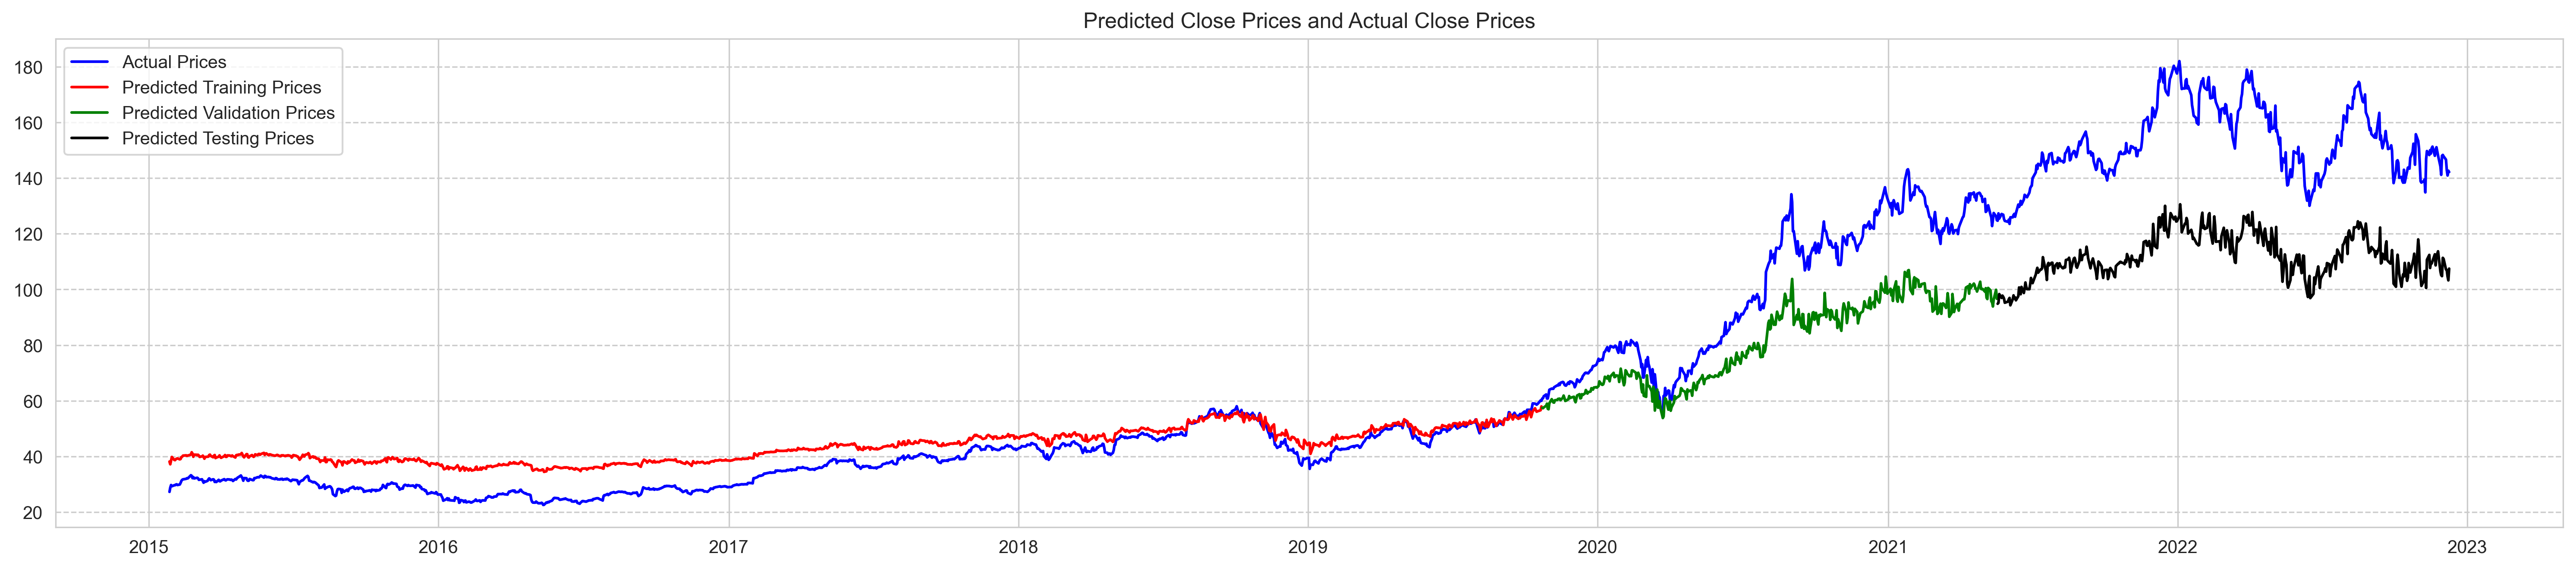

1187 395 395
1187 395 395
395
(1187, 15)
(1187, 15)
{'ae': 1493.4624, 'mape': 0.4079127, 'me': -0.08239441, 'mae': 0.08387882, 'mpe': -0.39974198, 'rmse': 0.17457942193694265, 'corr': 0.9218960295791806, 'minmax': 0.4076031446456909}
(395, 15)
{'ae': 682.97186, 'mape': 0.21003634, 'me': 0.01997319, 'mae': 0.11526951, 'mpe': 0.10760668, 'rmse': 0.18972357882878366, 'corr': 0.9247843716380982, 'minmax': 0.1768275499343872}
(395, 15)
{'ae': 1127.7935, 'mape': 0.2648196, 'me': 0.099131376, 'mae': 0.19034488, 'mpe': 0.20018019, 'rmse': 0.24034888166981244, 'corr': 0.3168742616300825, 'minmax': 0.2075507640838623}
(1187, 15)
(395, 15)
(395, 15)
(1977,)
(1977,)
predict (1187,)
Train Loss: 6.298425362706687
Val Loss: 18.915122869950306
Test Loss: 41.01432122339176
predict (1187,)
val_predict (395,)
test_predict (395,)


C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


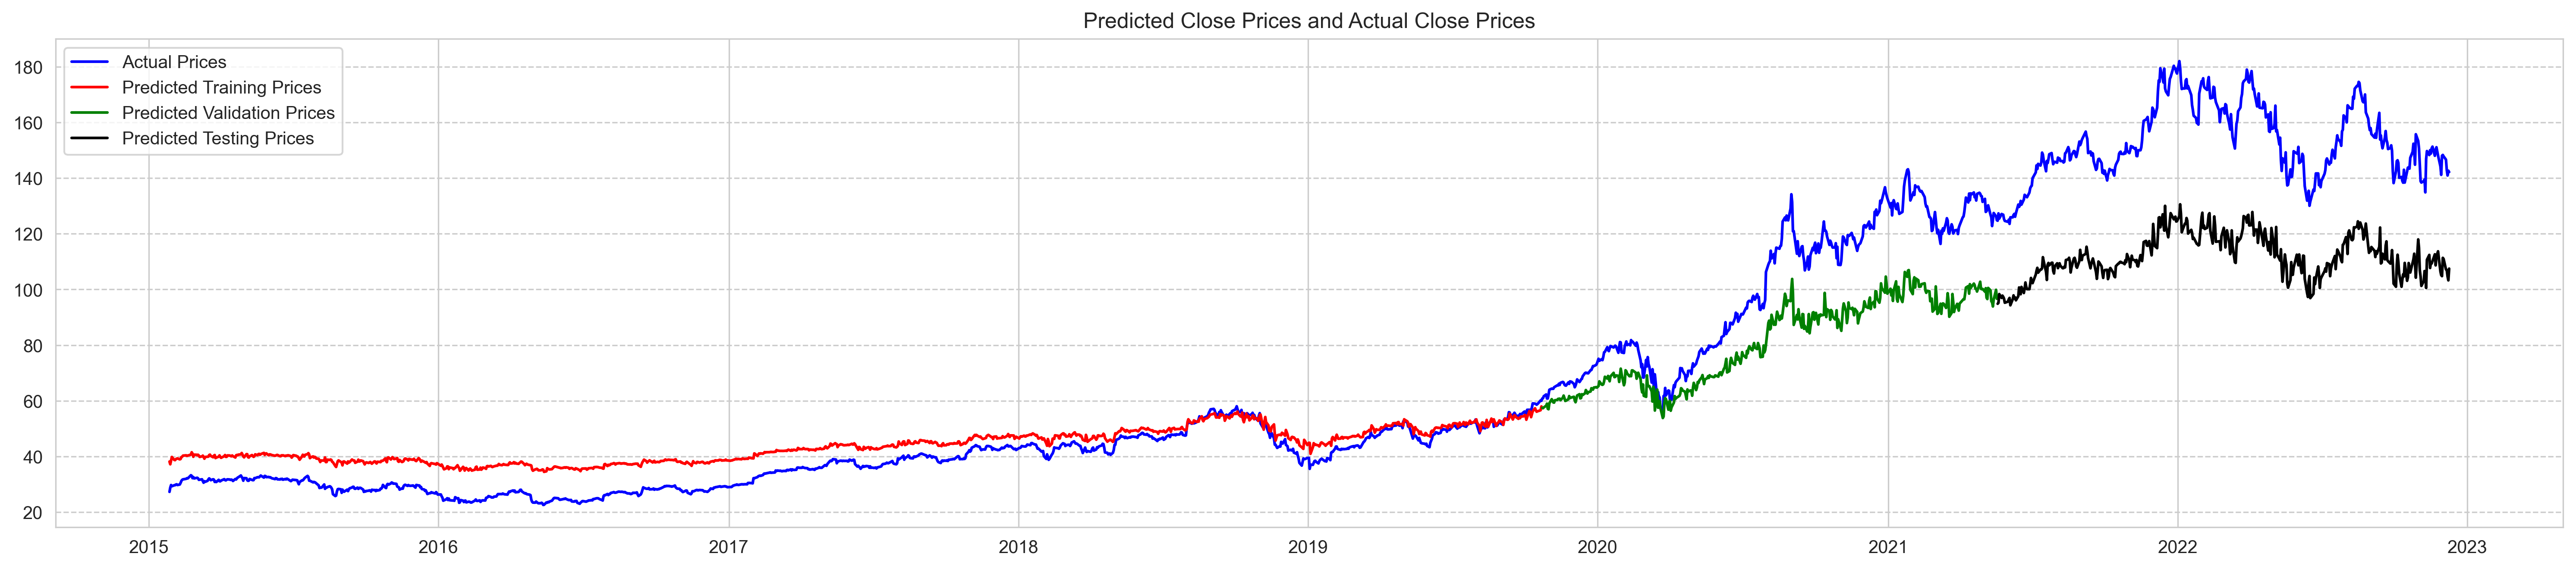

1187 395 395
1187 395 395
395
(1187, 15)
(1187, 15)
{'ae': 1493.4624, 'mape': 0.4079127, 'me': -0.08239441, 'mae': 0.08387882, 'mpe': -0.39974198, 'rmse': 0.17457942193694265, 'corr': 0.9218960295791806, 'minmax': 0.4076031446456909}
(395, 15)
{'ae': 682.97186, 'mape': 0.21003634, 'me': 0.01997319, 'mae': 0.11526951, 'mpe': 0.10760668, 'rmse': 0.18972357882878366, 'corr': 0.9247843716380982, 'minmax': 0.1768275499343872}
(395, 15)
{'ae': 1127.7935, 'mape': 0.2648196, 'me': 0.099131376, 'mae': 0.19034488, 'mpe': 0.20018019, 'rmse': 0.24034888166981244, 'corr': 0.3168742616300825, 'minmax': 0.2075507640838623}
(1187, 15)
(395, 15)
(395, 15)


({'ae': 1493.4624,
  'mape': 0.4079127,
  'me': -0.08239441,
  'mae': 0.08387882,
  'mpe': -0.39974198,
  'rmse': 0.17457942193694265,
  'corr': 0.9218960295791806,
  'minmax': 0.4076031446456909},
 {'ae': 682.97186,
  'mape': 0.21003634,
  'me': 0.01997319,
  'mae': 0.11526951,
  'mpe': 0.10760668,
  'rmse': 0.18972357882878366,
  'corr': 0.9247843716380982,
  'minmax': 0.1768275499343872},
 {'ae': 1127.7935,
  'mape': 0.2648196,
  'me': 0.099131376,
  'mae': 0.19034488,
  'mpe': 0.20018019,
  'rmse': 0.24034888166981244,
  'corr': 0.3168742616300825,
  'minmax': 0.2075507640838623})

In [423]:
lookback = 16 # choose sequence length
pred_length = 15
AAPL_df = pd.read_csv('Preprocessed_AAPL_Data.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
AAPL_df = AAPL_df[['Date', 'Close']]
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =False, num_features = 47) # change the num_feature value for using more features
# x_test = np.squeeze(x_test)

# .repeat(2, 1)
# x_train = x_train.repeat(1, 2)
# x_train = x_train.repeat(1, 2)
print(x_train[0])

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
# x_train = x_train.repeat(1, 1, 2)
# x_val = x_val.repeat(1, 1, 2)
# x_test = x_test.repeat(1, 1, 2)
# print('x_train.shape = ', x_train.size())
# print('y_train.shape = ', y_train.size())
# print('x_test.shape = ', x_test.size())

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_seq = len(x_train[0])
input_dim = len(x_train[0][0])
print(input_dim)
hidden_dim = 96
emsize = input_dim  # embedding dimension 192
d_hid = 96 # dimension of the feedforward network model in nn.TransformerEncoder 192
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
nhead = 5  # number of heads in nn.MultiheadAttention 12
dropout = 0.1  # dropout probability 0.1
num_layers = 3
output_dim = pred_length
print(input_dim)
# model = AttentionalLSTM(input_dim, output_dim, hidden_dim, num_layers, output_dim)
# model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
# model = Sequence_2_Conv(emsize,input_seq, hidden_dim, nlayers, output_dim, dropout)
model = SCINet(output_len = 15, input_len= 16, input_dim = input_dim, hid_size = 128, num_stacks = 1,
                num_levels = 2, concat_len = 0, groups = 1, kernel = 3, dropout = 0.1,
                 single_step_output_One = 0, positionalE =  True, modified = True)

# model = TransAm()
if train_on_gpu:
    model.cuda()
MAE_Loss = nn.L1Loss()
# MAE_Loss = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))
results_dic['SCINet_price']=str(evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length))
evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

In [424]:
with open("SCINet_Results.json", "w") as fp:
    json.dump(results_dic,fp) 

In [ ]:
lookback = 15 # choose sequence length
pred_length = 15
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length, use_PCA =True, num_features = 47) # change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_seq = len(x_train[0])
input_dim = len(x_train[0][0])
print(input_dim)
hidden_dim = 128
emsize = input_dim  # embedding dimension 192
d_hid = 96 # dimension of the feedforward network model in nn.TransformerEncoder 192
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
nhead = 5  # number of heads in nn.MultiheadAttention 12
dropout = 0.1  # dropout probability 0.1
num_layers = 1
output_dim = pred_length
print(input_dim)

# model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
model = Sequence_2_Conv(emsize,input_seq, hidden_dim, nlayers, output_dim, dropout)

# model = TransAm()
if train_on_gpu:
    model.cuda()
# MAE_Loss = nn.L1Loss()
MAE_Loss = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))

evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

In [ ]:
AAPL_df['Close'][-16:]

In [343]:
model.eval()
test_index = -1
test_input = torch.unsqueeze(x_test[test_index],0)
test_output = model(test_input.cuda()).detach().cpu().numpy()
test_output = denormalise(AAPL_df, test_output)
test_output

array([[142.65   , 142.7435 , 142.65   , 142.65   , 142.87189, 142.65   ,
        142.91603, 143.00774, 143.07147, 143.13806, 143.17126, 143.22588,
        143.24411, 143.31763, 143.38046]], dtype=float32)